In [2]:
import numpy as np
import cv2
from pathlib import Path
import os
import pandas as pd
from skimage.feature import local_binary_pattern
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
import shap
import joblib
import pandas as pd


In [3]:
def extract_pixel_features(image, window_size=15):
    """
    Extract features for each pixel using local neighborhoods
    
    Args:
        image: RGB image (H, W, 3)
        window_size: Size of local window around each pixel
        
    Returns:
        features: Array of shape (H*W, num_features)
    """
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    
    h, w = image.shape[:2]
    
    features_list = []
    
    # 1. RGB values at each pixel (3 features)
    rgb_features = image.reshape(-1, 3)
    features_list.append(rgb_features)
    
    # 2. HSV values at each pixel (3 features)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_features = hsv.reshape(-1, 3)
    features_list.append(hsv_features)
    
    # 3. Local color statistics in neighborhood (6 features: mean & std for RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    for channel in range(3):
        ch = image[:, :, channel].astype(np.float32)
        
        # Local mean
        local_mean = cv2.blur(ch, (window_size, window_size))
        features_list.append(local_mean.reshape(-1, 1))
        
        # Local std (approximate)
        local_mean_sq = cv2.blur(ch**2, (window_size, window_size))
        local_std = np.sqrt(np.maximum(local_mean_sq - local_mean**2, 0))
        features_list.append(local_std.reshape(-1, 1))
    
    # 4. Local texture features
    # LBP (Local Binary Pattern) - captures local texture
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    features_list.append(lbp.reshape(-1, 1))
    
    # Local contrast (Laplacian)
    local_contrast = cv2.Laplacian(gray.astype(np.float32), cv2.CV_32F)
    features_list.append(np.abs(local_contrast).reshape(-1, 1))
    
    # 5. Edge strength at each pixel
    edges_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    edges_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(edges_x**2 + edges_y**2)
    features_list.append(edge_magnitude.reshape(-1, 1))
    
    # 6. Local saturation statistics
    saturation = hsv[:, :, 1].astype(np.float32)
    local_sat_mean = cv2.blur(saturation, (window_size, window_size))
    features_list.append(local_sat_mean.reshape(-1, 1))
    
    # 7. Position features (normalized x, y)
    y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    features_list.append((x_coords / w).reshape(-1, 1))
    features_list.append((y_coords / h).reshape(-1, 1))
    
    # Concatenate all features
    features = np.hstack(features_list)
    
    return features

In [4]:
def calculate_iou_metrics(model, X_test, y_test, image_shapes=None):
    """
    Calculate mean IOU for segmentation quality
    
    Args:
        model: Trained classifier
        X_test: Test features
        y_test: Test labels
        image_shapes: List of (height, width) for each image (optional)
        
    Returns:
        IOU metrics dictionary
    """
    from sklearn.metrics import jaccard_score
    
    print("\n" + "="*60)
    print("CALCULATING IOU METRICS")
    print("="*60)
    
    # Convert labels to binary
    y_binary = (y_test == 2).astype(int)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate IOU for each class
    iou_healthy = jaccard_score(y_binary, y_pred, pos_label=0, average='binary')
    iou_bleached = jaccard_score(y_binary, y_pred, pos_label=1, average='binary')
    mean_iou = (iou_healthy + iou_bleached) / 2
    
    # Overall IOU (macro average)
    iou_macro = jaccard_score(y_binary, y_pred, average='macro')
    
    print(f"\nIOU Metrics:")
    print(f"  Healthy Coral IOU:   {iou_healthy:.4f}")
    print(f"  Bleached Coral IOU:  {iou_bleached:.4f}")
    print(f"  Mean IOU:            {mean_iou:.4f}")
    print(f"  Macro IOU:           {iou_macro:.4f}")
    
    # Calculate per-class metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision_healthy = precision_score(y_binary, y_pred, pos_label=0)
    recall_healthy = recall_score(y_binary, y_pred, pos_label=0)
    f1_healthy = f1_score(y_binary, y_pred, pos_label=0)
    
    precision_bleached = precision_score(y_binary, y_pred, pos_label=1)
    recall_bleached = recall_score(y_binary, y_pred, pos_label=1)
    f1_bleached = f1_score(y_binary, y_pred, pos_label=1)
    
    print(f"\nDetailed Metrics:")
    print(f"\n  Healthy Coral:")
    print(f"    Precision: {precision_healthy:.4f}")
    print(f"    Recall:    {recall_healthy:.4f}")
    print(f"    F1-Score:  {f1_healthy:.4f}")
    print(f"    IOU:       {iou_healthy:.4f}")
    
    print(f"\n  Bleached Coral:")
    print(f"    Precision: {precision_bleached:.4f}")
    print(f"    Recall:    {recall_bleached:.4f}")
    print(f"    F1-Score:  {f1_bleached:.4f}")
    print(f"    IOU:       {iou_bleached:.4f}")
    
    metrics = {
        'iou_healthy': iou_healthy,
        'iou_bleached': iou_bleached,
        'mean_iou': mean_iou,
        'iou_macro': iou_macro,
        'precision_healthy': precision_healthy,
        'recall_healthy': recall_healthy,
        'f1_healthy': f1_healthy,
        'precision_bleached': precision_bleached,
        'recall_bleached': recall_bleached,
        'f1_bleached': f1_bleached
    }
    
    return metrics, y_pred


def visualize_iou_results(metrics):
    """
    Visualize IOU and other metrics
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # IOU comparison
    iou_data = pd.DataFrame({
        'Class': ['Healthy', 'Bleached', 'Mean'],
        'IOU': [metrics['iou_healthy'], metrics['iou_bleached'], metrics['mean_iou']]
    })
    
    colors = ['#2ecc71', '#e74c3c', '#3498db']
    bars = axes[0].bar(iou_data['Class'], iou_data['IOU'], color=colors, alpha=0.7)
    axes[0].set_ylabel('IOU Score', fontsize=12)
    axes[0].set_title('Intersection over Union (IOU) by Class', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Comprehensive metrics comparison
    metrics_data = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score', 'IOU'] * 2,
        'Score': [
            metrics['precision_healthy'], metrics['recall_healthy'], 
            metrics['f1_healthy'], metrics['iou_healthy'],
            metrics['precision_bleached'], metrics['recall_bleached'],
            metrics['f1_bleached'], metrics['iou_bleached']
        ],
        'Class': ['Healthy']*4 + ['Bleached']*4
    })
    
    import seaborn as sns
    sns.barplot(data=metrics_data, x='Metric', y='Score', hue='Class', 
                palette=['#2ecc71', '#e74c3c'], ax=axes[1], alpha=0.7)
    axes[1].set_ylabel('Score', fontsize=12)
    axes[1].set_title('Comprehensive Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylim([0, 1])
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].legend(title='Class', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('iou_metrics.png', dpi=150, bbox_inches='tight')
    print("\n✓ IOU metrics visualization saved to 'iou_metrics.png'")
    plt.show()

In [5]:
# Load and extract pixel features from one image
data_dir = '/kaggle/input/coral-prossessed/coral_dataset_final'
split = 'train'
data_path = Path(data_dir) / split
image_files = [f for f in os.listdir(data_path / 'images') if f.endswith('.npy')]

# Take first image as example
img_file = image_files[0]
base_name = os.path.splitext(img_file)[0]

print(f"Loading image: {base_name}")
print("="*70)

# Load image and masks
image = np.load(data_path / 'images' / img_file)
bleach_mask = np.load(data_path / 'masks_bleached' / f'{base_name}_bleached.npy')
healthy_mask = np.load(data_path / 'masks_non_bleached' / f'{base_name}_non_bleached.npy')

print(f"\nImage shape: {image.shape}")
print(f"Image value range: [{image.min():.3f}, {image.max():.3f}]")

# Create pixel labels
labels = np.zeros(image.shape[:2], dtype=np.int64)
labels[healthy_mask == 1] = 1  # Healthy coral
labels[bleach_mask == 1] = 2   # Bleached coral
labels_flat = labels.reshape(-1)

print(f"\nPixel label distribution:")
print(f"  Background (0): {np.sum(labels_flat == 0):,} pixels ({np.sum(labels_flat==0)/len(labels_flat)*100:.1f}%)")
print(f"  Healthy (1): {np.sum(labels_flat == 1):,} pixels ({np.sum(labels_flat==1)/len(labels_flat)*100:.1f}%)")
print(f"  Bleached (2): {np.sum(labels_flat == 2):,} pixels ({np.sum(labels_flat==2)/len(labels_flat)*100:.1f}%)")

# Extract pixel features
print("\n" + "="*70)
print("Extracting pixel-level features...")
print("="*70)

features = extract_pixel_features(image, window_size=15)
features

Loading image: C11_PB_PSA_T2_19nov24_HBenavides_Corr

Image shape: (512, 512, 3)
Image value range: [0.106, 0.953]

Pixel label distribution:
  Background (0): 261,086 pixels (99.6%)
  Healthy (1): 1,058 pixels (0.4%)
  Bleached (2): 0 pixels (0.0%)

Extracting pixel-level features...


array([[1.39000000e+02, 1.48000000e+02, 9.30000000e+01, ...,
        9.56133347e+01, 0.00000000e+00, 0.00000000e+00],
       [1.39000000e+02, 1.48000000e+02, 9.30000000e+01, ...,
        9.55599976e+01, 1.95312500e-03, 0.00000000e+00],
       [1.38000000e+02, 1.47000000e+02, 9.20000000e+01, ...,
        9.54800034e+01, 3.90625000e-03, 0.00000000e+00],
       ...,
       [1.27000000e+02, 1.13000000e+02, 7.40000000e+01, ...,
        9.58711090e+01, 9.94140625e-01, 9.98046875e-01],
       [1.27000000e+02, 1.12000000e+02, 7.10000000e+01, ...,
        9.76266632e+01, 9.96093750e-01, 9.98046875e-01],
       [1.26000000e+02, 1.11000000e+02, 7.00000000e+01, ...,
        9.75066681e+01, 9.98046875e-01, 9.98046875e-01]])

In [6]:
feature_names = [
    'R', 'G', 'B',                           # RGB (3)
    'H', 'S', 'V',                           # HSV (3)
    'R_local_mean', 'R_local_std',           # R local stats (2)
    'G_local_mean', 'G_local_std',           # G local stats (2)
    'B_local_mean', 'B_local_std',           # B local stats (2)
    'LBP',                                   # Local Binary Pattern (1)
    'Local_contrast',                        # Contrast (1)
    'Edge_magnitude',                        # Edge strength (1)
    'Saturation_local_mean',                 # Saturation (1)
    'X_position', 'Y_position'               # Position (2)
]

print(f"\nFeature names ({len(feature_names)} features):")
for i, name in enumerate(feature_names):
    print(f"  {i:2d}. {name}")

# Create DataFrame for sample pixels
print("\n" + "="*70)
print("Sample pixel features (first 10 pixels):")
print("="*70)

df_sample = pd.DataFrame(features[:10], columns=feature_names)
df_sample['Label'] = labels_flat[:10]
df_sample['Label_Name'] = df_sample['Label'].map({0: 'Background', 1: 'Healthy', 2: 'Bleached'})

df_sample.head()



Feature names (18 features):
   0. R
   1. G
   2. B
   3. H
   4. S
   5. V
   6. R_local_mean
   7. R_local_std
   8. G_local_mean
   9. G_local_std
  10. B_local_mean
  11. B_local_std
  12. LBP
  13. Local_contrast
  14. Edge_magnitude
  15. Saturation_local_mean
  16. X_position
  17. Y_position

Sample pixel features (first 10 pixels):


,R,G,B,H,S,V,R_local_mean,R_local_std,G_local_mean,G_local_std,B_local_mean,B_local_std,LBP,Local_contrast,Edge_magnitude,Saturation_local_mean,X_position,Y_position,Label,Label_Name
0,139.0,148.0,93.0,35.0,95.0,148.0,129.773331,6.237331,139.573334,5.987781,87.239998,4.411621,1.0,2.0,0.0,95.613335,0.000000,0.0,0,Background
1,139.0,148.0,93.0,35.0,95.0,148.0,129.871109,6.341055,139.671112,6.091746,87.337776,4.519759,1.0,3.0,2.0,95.559998,0.001953,0.0,0,Background
2,138.0,147.0,92.0,35.0,95.0,147.0,129.986664,6.436438,139.786667,6.187342,87.453331,4.619718,5.0,1.0,2.0,95.480003,0.003906,0.0,0,Background
3,138.0,147.0,92.0,35.0,95.0,147.0,130.080002,6.479535,139.880005,6.230124,87.546669,4.663637,5.0,0.0,0.0,95.408890,0.005859,0.0,0,Background
4,138.0,147.0,92.0,35.0,95.0,147.0,130.186661,6.478179,139.986664,6.229341,87.653336,4.666097,9.0,0.0,2.0,95.333336,0.007812,0.0,0,Background


In [7]:
import xgboost as xgb
def load_dataset(data_dir, split='train', max_images=None, sample_ratio=1.0):
    """
    Load images and extract features for training/validation
    
    Args:
        data_dir: Path to dataset directory
        split: 'train' or 'val'
        max_images: Maximum number of images to load (None for all)
        sample_ratio: Ratio of pixels to sample per image (to manage memory)
        
    Returns:
        X: Feature array
        y: Label array
    """
    data_path = Path(data_dir) / split
    image_files = sorted([f for f in os.listdir(data_path / 'images') if f.endswith('.npy')])
    
    if max_images:
        image_files = image_files[:max_images]
    
    X_list = []
    y_list = []
    
    print(f"\nLoading {split} data from {len(image_files)} images...")
    
    for img_file in tqdm(image_files):
        base_name = os.path.splitext(img_file)[0]
        
        # Load image and masks
        image = np.load(data_path / 'images' / img_file)
        bleach_mask = np.load(data_path / 'masks_bleached' / f'{base_name}_bleached.npy')
        healthy_mask = np.load(data_path / 'masks_non_bleached' / f'{base_name}_non_bleached.npy')
        
        # Create labels
        labels = np.zeros(image.shape[:2], dtype=np.int64)
        labels[healthy_mask == 1] = 1  # Healthy coral
        labels[bleach_mask == 1] = 2   # Bleached coral
        labels_flat = labels.reshape(-1)
        
        # Extract features
        features = extract_pixel_features(image, window_size=15)
        
        # Filter out background pixels (label 0) and sample
        coral_mask = labels_flat > 0
        coral_features = features[coral_mask]
        coral_labels = labels_flat[coral_mask]
        
        # Sample if needed
        if sample_ratio < 1.0 and len(coral_labels) > 0:
            n_samples = int(len(coral_labels) * sample_ratio)
            indices = np.random.choice(len(coral_labels), n_samples, replace=False)
            coral_features = coral_features[indices]
            coral_labels = coral_labels[indices]
        
        X_list.append(coral_features)
        y_list.append(coral_labels)
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    return X, y


def train_classifier(X_train, y_train, model):
    """
    Train XGBoost classifier on GPU
    
    Args:
        X_train: Training features
        y_train: Training labels
        n_estimators: Number of trees
        max_depth: Maximum tree depth
        
    Returns:
        Trained model
    """
    print("\nTraining XGBoost classifier on GPU...")
    print(f"  n_estimators: {n_estimators}")
    print(f"  max_depth: {max_depth}")
    print(f"  Training samples: {len(X_train):,}")
    
    # Convert labels to binary (1: healthy -> 0, 2: bleached -> 1)
    y_binary = (y_train == 2).astype(int)
    
    # Calculate class distribution
    n_healthy = np.sum(y_binary == 0)
    n_bleached = np.sum(y_binary == 1)
    scale_pos_weight = n_healthy / n_bleached
    
    print(f"  Healthy samples: {n_healthy:,}")
    print(f"  Bleached samples: {n_bleached:,}")
    print(f"  Scale pos weight: {scale_pos_weight:.2f}")
    
    model.fit(X_train, y_binary)
    
    return model


def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance
    
    Args:
        model: Trained classifier
        X_test: Test features
        y_test: Test labels
        
    Returns:
        Predictions and metrics
    """
    print("\nEvaluating model...")
    
    # Convert labels to binary
    y_binary = (y_test == 2).astype(int)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_binary, y_pred)
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_binary, y_pred, 
                                target_names=['Healthy', 'Bleached'],
                                digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_binary, y_pred)
    
    return y_pred, y_proba, cm


def plot_results(cm, feature_importance, feature_names):
    """
    Plot confusion matrix and feature importance
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Healthy', 'Bleached'],
                yticklabels=['Healthy', 'Bleached'])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    top_n = 15
    sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', ax=axes[1])
    axes[1].set_title(f'Top {top_n} Feature Importance')
    
    plt.tight_layout()
    plt.savefig('coral_bleaching_results.png', dpi=150, bbox_inches='tight')
    print("\nResults saved to 'coral_bleaching_results.png'")
    plt.show()



In [8]:


# Configuration
DATA_DIR = '/kaggle/input/coral-prossessed/coral_dataset_final'
MAX_TRAIN_IMAGES = 50  # Limit to 50 images
MAX_VAL_IMAGES = None
SAMPLE_RATIO = 0.3

feature_names = [
    'R', 'G', 'B', 'H', 'S', 'V',
    'R_local_mean', 'R_local_std',
    'G_local_mean', 'G_local_std',
    'B_local_mean', 'B_local_std',
    'LBP', 'Local_contrast', 'Edge_magnitude',
    'Saturation_local_mean',
    'X_position', 'Y_position'
]

# Load training data
X_train, y_train = load_dataset(DATA_DIR, 'train', 
                                 max_images=MAX_TRAIN_IMAGES,
                                 sample_ratio=SAMPLE_RATIO)
print(f"\nTraining data loaded:")
print(f"  Features shape: {X_train.shape}")
print(f"  Labels shape: {y_train.shape}")
print(f"  Healthy pixels: {np.sum(y_train == 1):,}")
print(f"  Bleached pixels: {np.sum(y_train == 2):,}")

# Load validation data
X_val, y_val = load_dataset(DATA_DIR, 'val',
                             max_images=MAX_VAL_IMAGES,
                             sample_ratio=SAMPLE_RATIO)
print(f"\nValidation data loaded:")
print(f"  Features shape: {X_val.shape}")
print(f"  Labels shape: {y_val.shape}")





Loading train data from 50 images...


100%|██████████| 50/50 [00:10<00:00,  4.96it/s]



Training data loaded:
  Features shape: (1206930, 18)
  Labels shape: (1206930,)
  Healthy pixels: 817,535
  Bleached pixels: 389,395

Loading val data from 132 images...


100%|██████████| 132/132 [00:26<00:00,  5.01it/s]



Validation data loaded:
  Features shape: (3775061, 18)
  Labels shape: (3775061,)


In [9]:
n_estimators=100
max_depth=20
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    verbose=1
)

# Train model
model = train_classifier(X_train, y_train, model)

# Save model

joblib.dump(model, 'coral_bleaching_random_forest_gpu.pkl')
print("\nModel saved to 'coral_bleaching_random_forest_gpu.pkl'")

# Evaluate on validation set
y_pred, y_proba, cm = evaluate_model(model, X_val, y_val)


Training XGBoost classifier on GPU...
  n_estimators: 100
  max_depth: 20
  Training samples: 1,206,930
  Healthy samples: 817,535
  Bleached samples: 389,395
  Scale pos weight: 2.10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished



Model saved to 'coral_bleaching_random_forest_gpu.pkl'

Evaluating model...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   29.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   29.9s finished



Accuracy: 0.7400

Classification Report:
              precision    recall  f1-score   support

     Healthy     0.8573    0.7539    0.8023   2641059
    Bleached     0.5525    0.7077    0.6206   1134002

    accuracy                         0.7400   3775061
   macro avg     0.7049    0.7308    0.7114   3775061
weighted avg     0.7657    0.7400    0.7477   3775061



In [10]:
# n_estimators=100
# max_depth=20
# model = xgb.XGBClassifier(
#         tree_method='hist',  # Use 'hist' for GPU
#         device='cuda',  # Enable GPU
#         n_estimators=100,
#         max_depth=20,
#         learning_rate=0.1,
#         random_state=42,
#         eval_metric='logloss'
#     )
# # Train model
# model = train_classifier(X_train, y_train, model)

# # Save model
# joblib.dump(model, 'coral_bleaching_xgboost_gpu.pkl')
# print("\nModel saved to 'coral_bleaching_xgboost_gpu.pkl'")

# # Evaluate on validation set
# y_pred, y_proba, cm = evaluate_model(model, X_val, y_val)


Results saved to 'coral_bleaching_results.png'


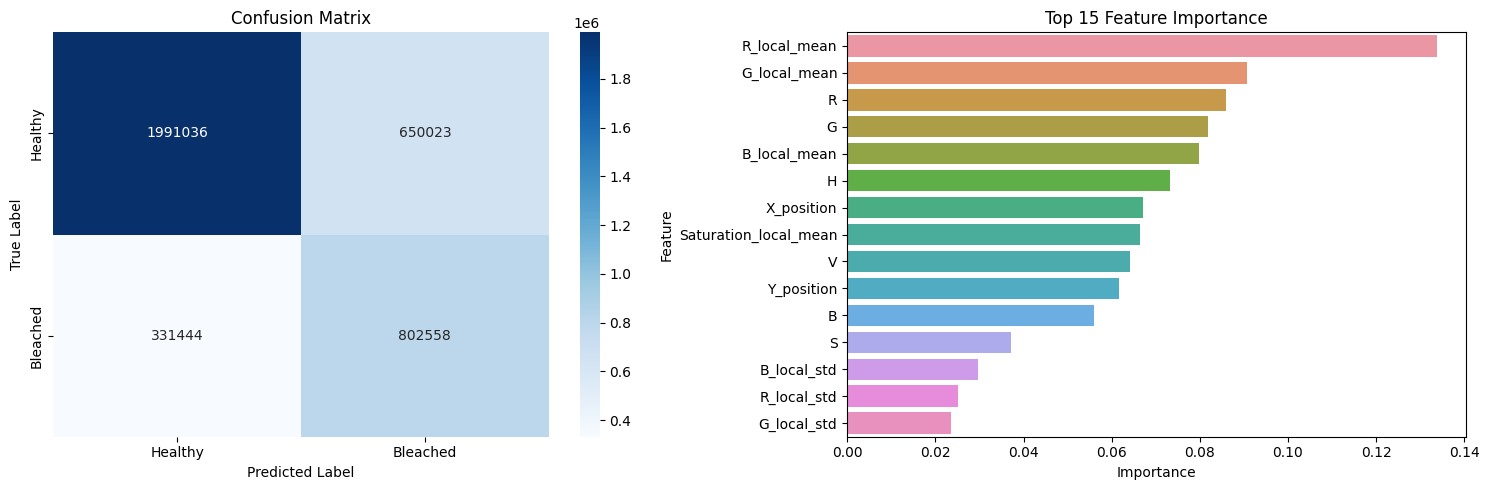


Making prediction on sample validation image...


In [11]:
import seaborn as sns
# Plot results
feature_importance = model.feature_importances_
plot_results(cm, feature_importance, feature_names)

# Example prediction on a single image
print("\n" + "="*70)
print("Making prediction on sample validation image...")
print("="*70)



CALCULATING IOU METRICS


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   30.1s finished



IOU Metrics:
  Healthy Coral IOU:   0.6698
  Bleached Coral IOU:  0.4499
  Mean IOU:            0.5598
  Macro IOU:           0.5598

Detailed Metrics:

  Healthy Coral:
    Precision: 0.8573
    Recall:    0.7539
    F1-Score:  0.8023
    IOU:       0.6698

  Bleached Coral:
    Precision: 0.5525
    Recall:    0.7077
    F1-Score:  0.6206
    IOU:       0.4499

✓ IOU metrics visualization saved to 'iou_metrics.png'


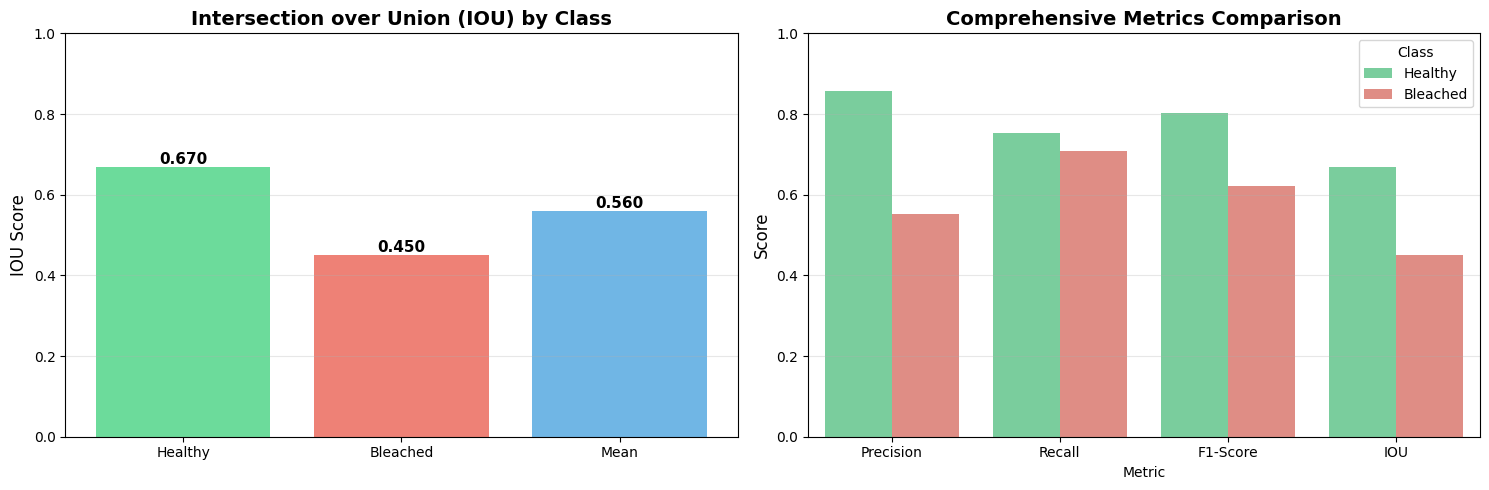

In [12]:
# Calculate and visualize IOU metrics
iou_metrics, y_pred_iou = calculate_iou_metrics(model, X_val, y_val)
visualize_iou_results(iou_metrics)

Total pixels: 262,144
Coral pixels: 77,420 (29.5%)
Predicting on coral pixels only...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished



PREDICTION METRICS (Coral Pixels Only)
Overall Accuracy: 0.8446 (65,392/77,420 pixels)

Healthy Coral:
  Ground Truth: 13,224 pixels
  ✓ Correctly Predicted: 12,928 (97.76%)
  ✗ Misclassified as Bleached: 296

Bleached Coral:
  Ground Truth: 64,196 pixels
  ✓ Correctly Predicted: 52,464 (81.72%)
  ✗ Misclassified as Healthy: 11,732

Visualization saved to 'sample_prediction.png'


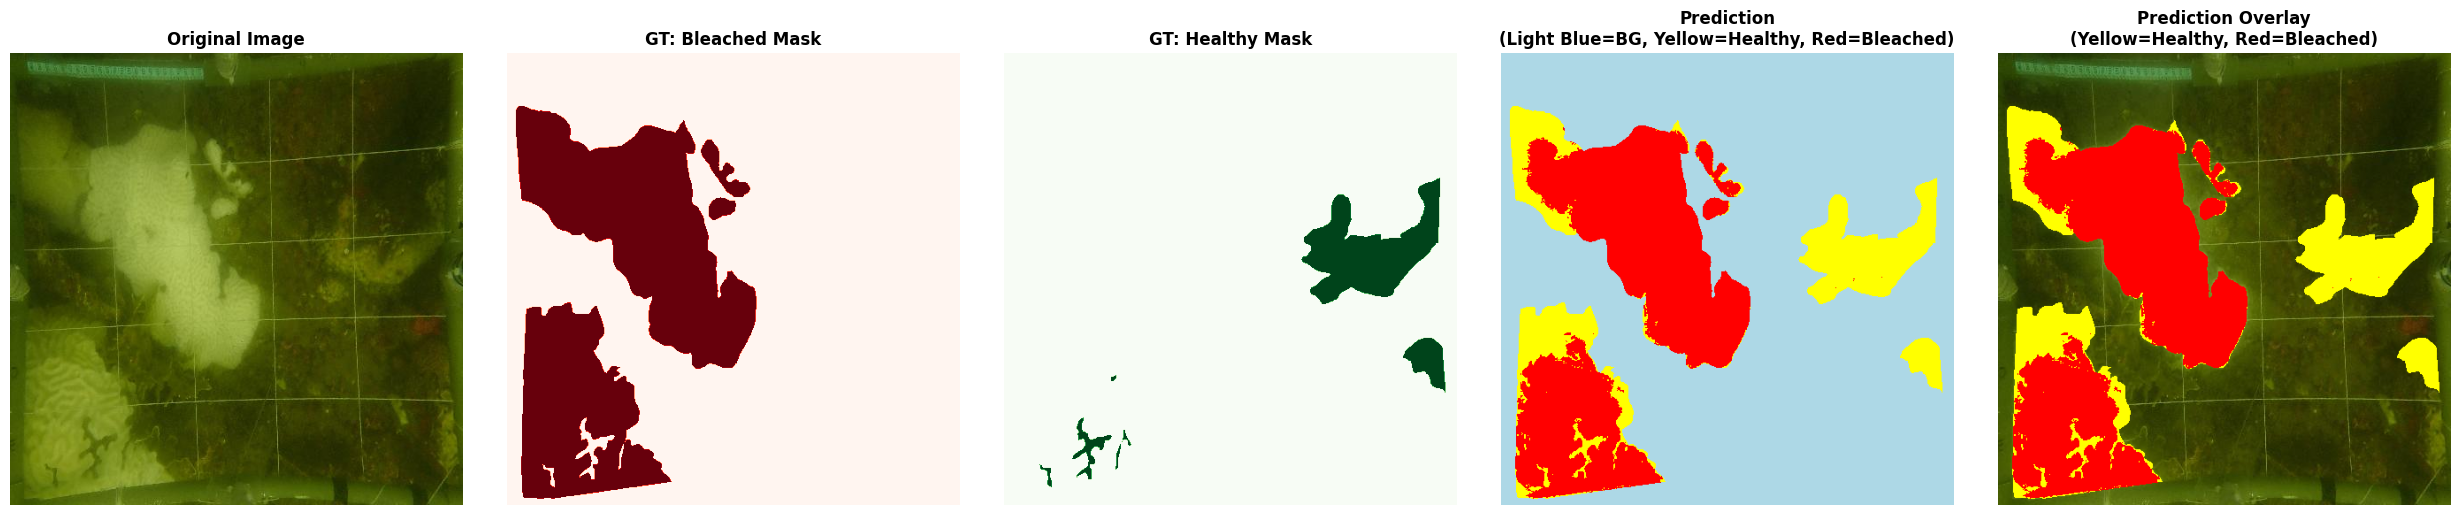


PREDICTION SUMMARY: C10_BC_PSb_T1_29nov24_HBenavides_corr.npy
Background pixels: 184,724
Healthy coral pixels: 24,660
Bleached coral pixels: 52,760


In [ ]:
def predict_image(model, image_path, bleach_mask_path=None, healthy_mask_path=None, output_path=None):
    """
    Predict bleaching for a single image
    
    Args:
        model: Trained classifier (predicts 0=healthy, 1=bleached for coral pixels only)
        image_path: Path to image
        bleach_mask_path: Path to ground truth bleached mask (optional)
        healthy_mask_path: Path to ground truth healthy mask (optional)
        output_path: Path to save prediction visualization
        
    Returns:
        Prediction mask (0=background, 1=healthy coral, 2=bleached coral)
    """
    image = np.load(image_path)
    h, w = image.shape[:2]
    
    # Load ground truth masks if provided
    bleach_mask = None
    healthy_mask = None
    coral_mask = None
    
    if bleach_mask_path and os.path.exists(bleach_mask_path):
        bleach_mask = np.load(bleach_mask_path)
    if healthy_mask_path and os.path.exists(healthy_mask_path):
        healthy_mask = np.load(healthy_mask_path)
    
    # Create coral mask (any pixel that is either bleached or healthy)
    if bleach_mask is not None and healthy_mask is not None:
        coral_mask = (bleach_mask == 1) | (healthy_mask == 1)
    else:
        # If no masks provided, assume all non-black pixels are coral (fallback)
        # You might want a better heuristic here
        coral_mask = np.any(image > 0.1, axis=-1) if image.max() <= 1 else np.any(image > 25, axis=-1)
    
    # Extract features for ALL pixels first
    all_features = extract_pixel_features(image, window_size=15)
    
    # Get coral pixel indices
    coral_indices = coral_mask.flatten()
    
    # Filter to only coral pixels for prediction
    coral_features = all_features[coral_indices]
    
    print(f"Total pixels: {h * w:,}")
    print(f"Coral pixels: {np.sum(coral_indices):,} ({np.sum(coral_indices)/(h*w)*100:.1f}%)")
    print(f"Predicting on coral pixels only...")
    
    # Predict ONLY on coral pixels (model outputs 0=healthy, 1=bleached)
    coral_predictions = model.predict(coral_features)
    
    # Create full prediction mask (initially all background = 0)
    pred_mask = np.zeros(h * w, dtype=int)
    
    # Map coral predictions back to full image
    # Convert model output (0=healthy, 1=bleached) to our format (1=healthy, 2=bleached)
    pred_mask[coral_indices] = coral_predictions + 1  # 0->1 (healthy), 1->2 (bleached)
    
    # Reshape to 2D
    pred_mask = pred_mask.reshape(h, w)
    
    # Visualize
    if output_path:
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
        
        # 1. Original image
        axes[0].imshow(image)
        axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # 2. Ground truth bleached mask
        if bleach_mask is not None:
            axes[1].imshow(bleach_mask, cmap='Reds', vmin=0, vmax=1)
            axes[1].set_title('GT: Bleached Mask', fontsize=12, fontweight='bold')
        else:
            axes[1].text(0.5, 0.5, 'No Bleached Mask', ha='center', va='center', fontsize=14)
            axes[1].set_title('GT: Bleached Mask', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        # 3. Ground truth healthy mask
        if healthy_mask is not None:
            axes[2].imshow(healthy_mask, cmap='Greens', vmin=0, vmax=1)
            axes[2].set_title('GT: Healthy Mask', fontsize=12, fontweight='bold')
        else:
            axes[2].text(0.5, 0.5, 'No Healthy Mask', ha='center', va='center', fontsize=14)
            axes[2].set_title('GT: Healthy Mask', fontsize=12, fontweight='bold')
        axes[2].axis('off')
        
        # 4. Prediction mask (color-coded: light blue=background, yellow=healthy, red=bleached)
        pred_colored = np.zeros((h, w, 3), dtype=np.uint8)
        pred_colored[pred_mask == 0] = [173, 216, 230]   # Background: Light Blue
        pred_colored[pred_mask == 1] = [255, 255, 0]     # Healthy: Yellow
        pred_colored[pred_mask == 2] = [255, 0, 0]       # Bleached: Red
        
        axes[3].imshow(pred_colored)
        axes[3].set_title('Prediction\n(Light Blue=BG, Yellow=Healthy, Red=Bleached)', 
                         fontsize=12, fontweight='bold')
        axes[3].axis('off')
        
        # 5. Overlay on original image
        overlay = image.copy().astype(float)
        if overlay.max() > 1:
            overlay = overlay / 255.0
        overlay = (overlay * 255).astype(np.uint8)
        
        # Only color coral pixels
        overlay[pred_mask == 1] = [255, 255, 0]   # Yellow for healthy
        overlay[pred_mask == 2] = [255, 0, 0]     # Red for bleached
        
        axes[4].imshow(overlay)
        axes[4].set_title('Prediction Overlay\n(Yellow=Healthy, Red=Bleached)', 
                         fontsize=12, fontweight='bold')
        axes[4].axis('off')
        
        # Print accuracy metrics if ground truth is available
        if bleach_mask is not None and healthy_mask is not None:
            # Ground truth combined (for coral pixels only)
            gt_combined = np.zeros_like(bleach_mask, dtype=int)
            gt_combined[healthy_mask == 1] = 1   # Healthy = 1
            gt_combined[bleach_mask == 1] = 2    # Bleached = 2
            
            # Calculate accuracy only on coral pixels
            coral_pixels = np.sum(coral_mask)
            if coral_pixels > 0:
                # Overall accuracy on coral pixels
                correct = (pred_mask == gt_combined) & coral_mask
                accuracy = np.sum(correct) / coral_pixels
                
                # Detailed metrics
                correct_healthy = (pred_mask == 1) & (gt_combined == 1)
                correct_bleached = (pred_mask == 2) & (gt_combined == 2)
                false_bleached = (pred_mask == 2) & (gt_combined == 1)  # Predicted bleached, actually healthy
                false_healthy = (pred_mask == 1) & (gt_combined == 2)   # Predicted healthy, actually bleached
                
                # Calculate percentages for healthy and bleached
                total_healthy_gt = np.sum(gt_combined == 1)
                total_bleached_gt = np.sum(gt_combined == 2)
                
                healthy_accuracy = np.sum(correct_healthy) / total_healthy_gt if total_healthy_gt > 0 else 0
                bleached_accuracy = np.sum(correct_bleached) / total_bleached_gt if total_bleached_gt > 0 else 0
                
                print(f"\n{'='*70}")
                print("PREDICTION METRICS (Coral Pixels Only)")
                print(f"{'='*70}")
                print(f"Overall Accuracy: {accuracy:.4f} ({np.sum(correct):,}/{coral_pixels:,} pixels)")
                print(f"\nHealthy Coral:")
                print(f"  Ground Truth: {total_healthy_gt:,} pixels")
                print(f"  ✓ Correctly Predicted: {np.sum(correct_healthy):,} ({healthy_accuracy:.2%})")
                print(f"  ✗ Misclassified as Bleached: {np.sum(false_bleached):,}")
                print(f"\nBleached Coral:")
                print(f"  Ground Truth: {total_bleached_gt:,} pixels")
                print(f"  ✓ Correctly Predicted: {np.sum(correct_bleached):,} ({bleached_accuracy:.2%})")
                print(f"  ✗ Misclassified as Healthy: {np.sum(false_healthy):,}")
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"\nVisualization saved to '{output_path}'")
        plt.show()
    
    return pred_mask


# Example usage
val_path = Path(DATA_DIR) / 'val'
val_images = sorted([f for f in os.listdir(val_path / 'images') if f.endswith('.npy')])

if len(val_images) > 0:
    sample_image = val_path / 'images' / val_images[0]
    base_name = os.path.splitext(val_images[0])[0]
    
    # Get corresponding mask paths
    bleach_mask_path = val_path / 'masks_bleached' / f'{base_name}_bleached.npy'
    healthy_mask_path = val_path / 'masks_non_bleached' / f'{base_name}_non_bleached.npy'
    
    pred_mask = predict_image(
        model, 
        sample_image,
        bleach_mask_path=bleach_mask_path,
        healthy_mask_path=healthy_mask_path,
        output_path='sample_prediction.png'
    )
    
    print(f"\n{'='*70}")
    print(f"PREDICTION SUMMARY: {val_images[0]}")
    print(f"{'='*70}")
    print(f"Background pixels: {np.sum(pred_mask == 0):,}")
    print(f"Healthy coral pixels: {np.sum(pred_mask == 1):,}")
    print(f"Bleached coral pixels: {np.sum(pred_mask == 2):,}")

In [20]:
from lime import lime_tabular


In [22]:
def explain_with_lime(model, X_train, X_test, y_test, feature_names, num_samples=5):
    """
    Generate LIME explanations for sample predictions
    
    Args:
        model: Trained XGBoost model
        X_train: Training features (for LIME explainer initialization)
        X_test: Test features
        y_test: Test labels
        feature_names: List of feature names
        num_samples: Number of samples to explain
    """
    print("\n" + "="*60)
    print("GENERATING LIME EXPLANATIONS")
    print("="*60)
    
    # Convert labels to binary
    y_binary = (y_test == 2).astype(int)
    
    # Initialize LIME explainer
    print("\nInitializing LIME explainer...")
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=['Healthy', 'Bleached'],
        mode='classification',
        random_state=42
    )
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Select diverse samples to explain
    # Get some correct predictions and some incorrect ones
    correct_healthy = np.where((y_pred == 0) & (y_binary == 0))[0]
    correct_bleached = np.where((y_pred == 1) & (y_binary == 1))[0]
    incorrect = np.where(y_pred != y_binary)[0]
    
    sample_indices = []
    samples_per_type = num_samples // 3
    
    if len(correct_healthy) > 0:
        sample_indices.extend(np.random.choice(correct_healthy, 
                                              min(samples_per_type, len(correct_healthy)), 
                                              replace=False))
    if len(correct_bleached) > 0:
        sample_indices.extend(np.random.choice(correct_bleached, 
                                              min(samples_per_type, len(correct_bleached)), 
                                              replace=False))
    if len(incorrect) > 0:
        sample_indices.extend(np.random.choice(incorrect, 
                                              min(samples_per_type, len(incorrect)), 
                                              replace=False))
    
    sample_indices = sample_indices[:num_samples]
    
    print(f"\nExplaining {len(sample_indices)} predictions...")
    
    # Create figure for explanations
    fig, axes = plt.subplots(len(sample_indices), 1, figsize=(12, 5*len(sample_indices)))
    if len(sample_indices) == 1:
        axes = [axes]
    
    # Generate explanations
    for idx, sample_idx in enumerate(sample_indices):
        print(f"\nSample {idx+1}/{len(sample_indices)}:")
        
        instance = X_test[sample_idx]
        true_label = 'Bleached' if y_binary[sample_idx] == 1 else 'Healthy'
        pred_label = 'Bleached' if y_pred[sample_idx] == 1 else 'Healthy'
        confidence = y_proba[sample_idx, y_pred[sample_idx]]
        
        print(f"  True: {true_label}, Predicted: {pred_label}, Confidence: {confidence:.4f}")
        
        # Generate LIME explanation
        exp = explainer.explain_instance(
            data_row=instance,
            predict_fn=model.predict_proba,
            num_features=10,
            num_samples=5000
        )
        
        # Get explanation as list
        exp_list = exp.as_list()
        
        # Plot explanation
        features = [item[0] for item in exp_list]
        weights = [item[1] for item in exp_list]
        colors = ['green' if w > 0 else 'red' for w in weights]
        
        axes[idx].barh(features, weights, color=colors, alpha=0.7)
        axes[idx].set_xlabel('Feature Weight', fontsize=11)
        axes[idx].set_title(
            f'Sample {idx+1}: True={true_label}, Pred={pred_label} (conf={confidence:.3f})',
            fontsize=12, fontweight='bold'
        )
        axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', alpha=0.7, label='Supports Bleached'),
            Patch(facecolor='red', alpha=0.7, label='Supports Healthy')
        ]
        axes[idx].legend(handles=legend_elements, loc='best', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('lime_explanations.png', dpi=150, bbox_inches='tight')
    print("\n✓ LIME explanations saved to 'lime_explanations.png'")
    plt.show()
    
    return explainer


GENERATING LIME EXPLANATIONS

Initializing LIME explainer...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   30.3s finished



Explaining 6 predictions...

Sample 1/6:
  True: Healthy, Predicted: Healthy, Confidence: 0.7535


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.



Sample 2/6:
  True: Healthy, Predicted: Healthy, Confidence: 0.9924

Sample 3/6:
  True: Bleached, Predicted: Bleached, Confidence: 0.9999


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



Sample 4/6:
  True: Bleached, Predicted: Bleached, Confidence: 0.9240

Sample 5/6:
  True: Healthy, Predicted: Bleached, Confidence: 0.8540


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s



Sample 6/6:
  True: Healthy, Predicted: Bleached, Confidence: 0.9253


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



✓ LIME explanations saved to 'lime_explanations.png'


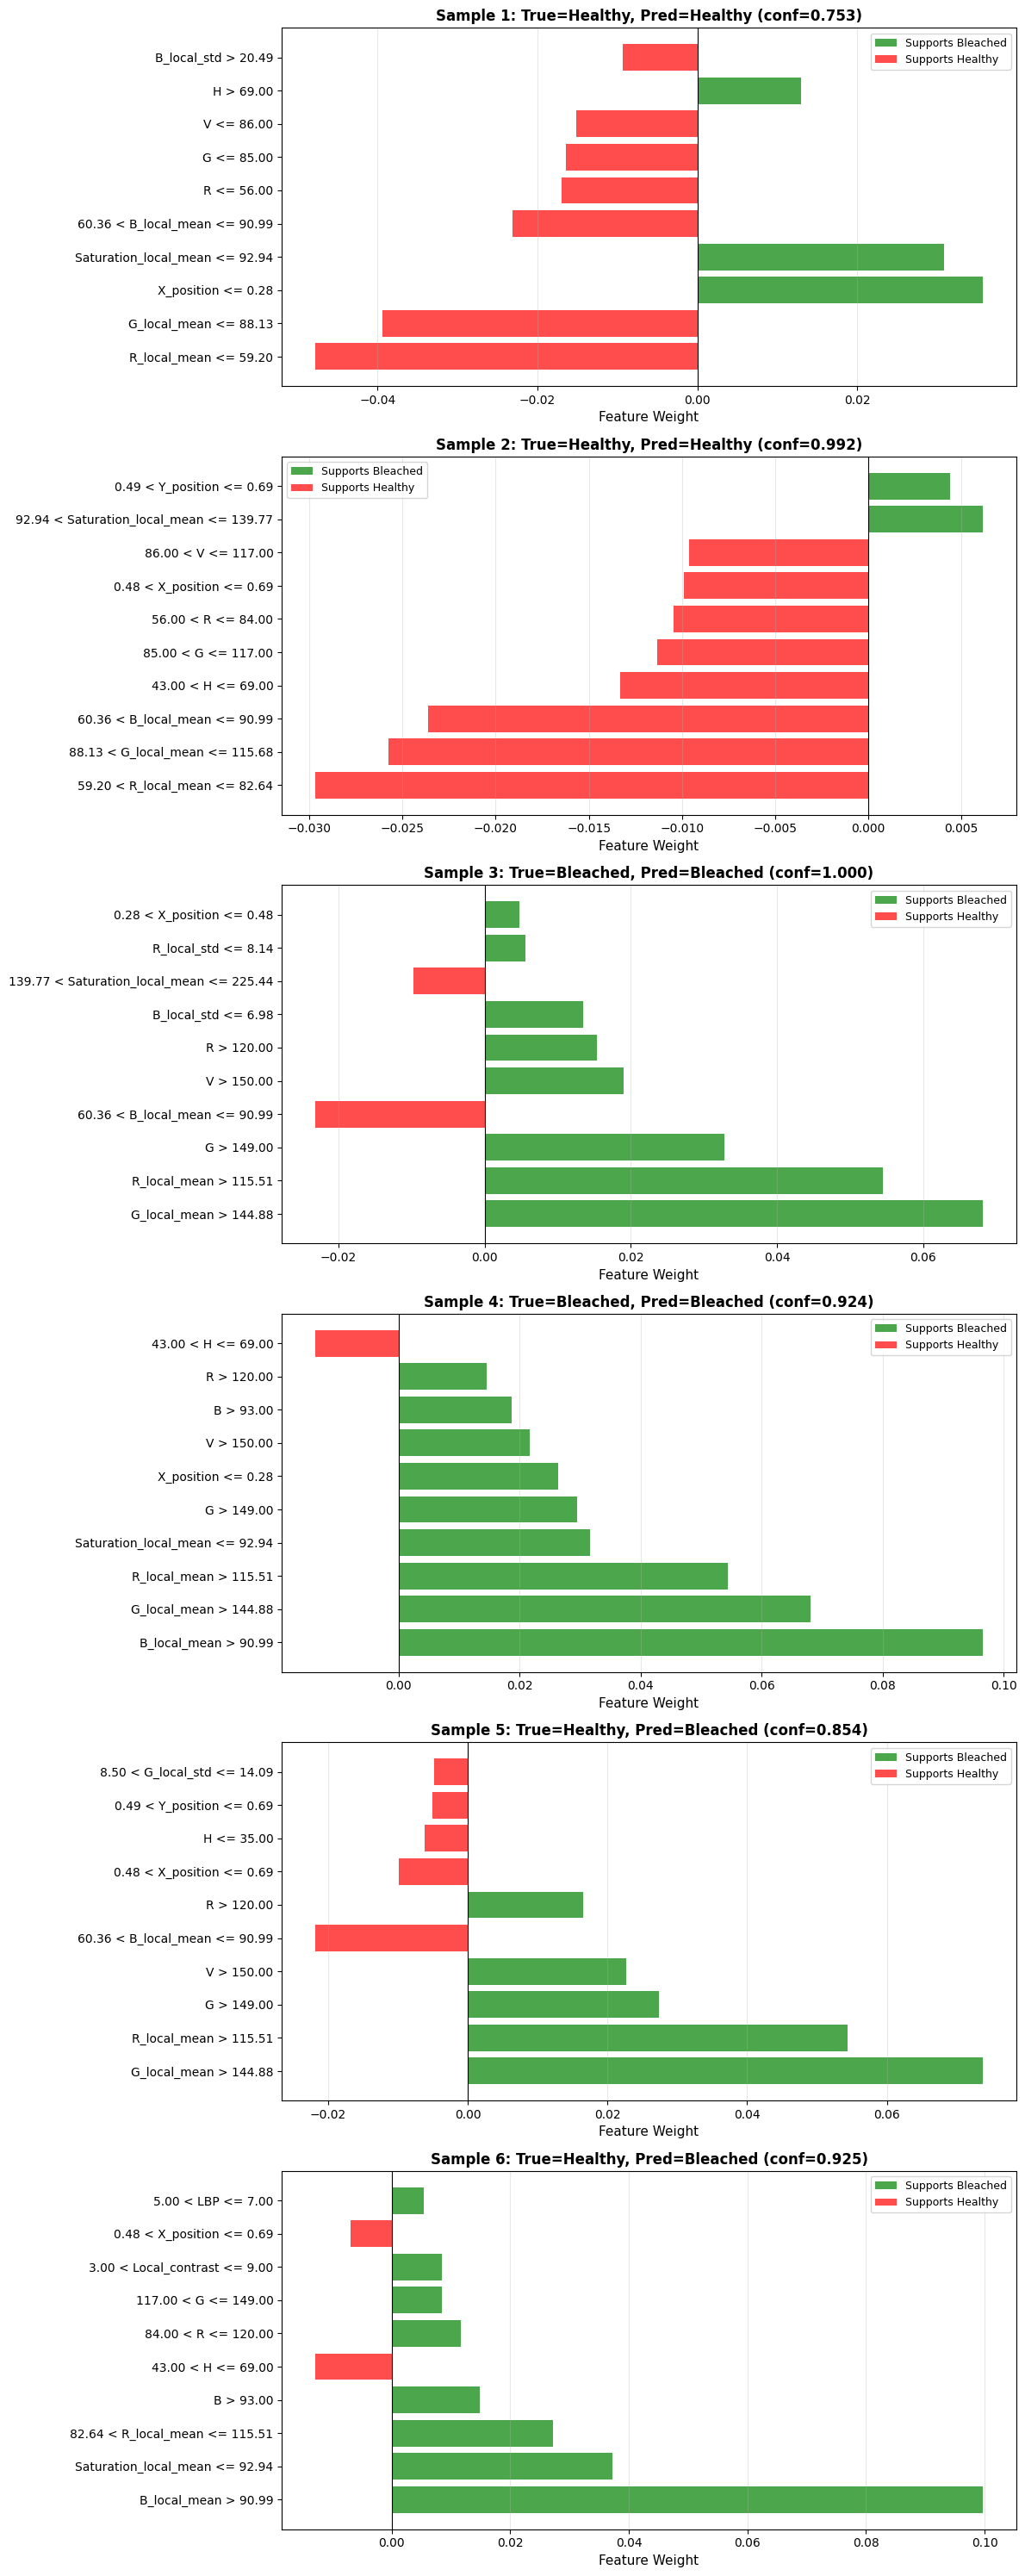

In [23]:
explainer = explain_with_lime(model, X_train, X_val, y_val, feature_names, num_samples=6)